In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import warnings

In [273]:
warnings.filterwarnings("ignore")

In [274]:
df = pd.read_csv("/content/day_01.csv")

In [275]:
df.head()

,day,time,0,1,2,3,4,5,6,7,...,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092
0,1,86400,NaN,NaN,NaN,7635,6832,NaN,845,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,86460,NaN,NaN,NaN,6924,6187,NaN,991,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,86520,NaN,NaN,NaN,6188,5614,NaN,1133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,86580,NaN,NaN,NaN,5106,4534,NaN,1141,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,86640,NaN,NaN,NaN,4533,4040,NaN,1239,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
def create_lags(df):
  df['lag_1'] = df['total_invocations'].shift(1)
  df['lag_2'] = df['total_invocations'].shift(2)
  df['lag_3'] = df['total_invocations'].shift(3)

  # random initial values for first row
  df['lag_1'].iloc[0] = np.random.randint(400, 600)
  df['lag_2'].iloc[0:2] = np.random.randint(400, 600, size=2)
  df['lag_3'].iloc[0:3] = np.random.randint(400, 600, size=3)
  return df


In [277]:
def get_preprocess_data_without_differencing(df):
  # Set reference start date (01 Nov 2023)
  start_date = pd.Timestamp("2023-11-01 00:00:00")
  df['datetime'] = start_date + pd.to_timedelta(df['time'], unit='s')

  # did the forward fill
  df = df.fillna(method='ffill', axis=1).fillna(0)

  # replaced columns named 0,1 and 2 with 0 since no prevoius value
  df[['0', '1', '2']] = 0

  function_columns = df.columns.difference(['day', 'time', 'datetime'])

  scaler = MinMaxScaler()
  df[function_columns] = scaler.fit_transform(df[function_columns])

  # sum the values from column named from 0 to 5092
  function_columns = df.columns.difference(['day', 'time', 'datetime'])
  df['total_invocations'] = df[function_columns].sum(axis=1).astype(int)
  # Retain only relevant columns
  df = df[['datetime', 'total_invocations']]

  create_lags(df)

  return df

In [278]:
def apply_differencing(df):
    df_diff = df.copy()  # Create a clone of the original DataFrame
    df_diff['diff_total_invocations'] = df_diff['total_invocations'].diff()
    df_diff = df_diff.dropna().reset_index(drop=True)  # Remove first NaN row due to differencing
    return df_diff


In [279]:
df_without_differencing =  get_preprocess_data_without_differencing(df)

In [280]:
differnced_preprocessed_df = apply_differencing(df_without_differencing)

In [281]:
df_without_differencing.head()

,datetime,total_invocations,lag_1,lag_2,lag_3
0,2023-11-02 00:00:00,501,489.0,565.0,509.0
1,2023-11-02 00:01:00,514,501.0,424.0,432.0
2,2023-11-02 00:02:00,485,514.0,501.0,404.0
3,2023-11-02 00:03:00,468,485.0,514.0,501.0
4,2023-11-02 00:04:00,503,468.0,485.0,514.0


In [282]:
differnced_preprocessed_df.head()

,datetime,total_invocations,lag_1,lag_2,lag_3,diff_total_invocations
0,2023-11-02 00:01:00,514,501.0,424.0,432.0,13.0
1,2023-11-02 00:02:00,485,514.0,501.0,404.0,-29.0
2,2023-11-02 00:03:00,468,485.0,514.0,501.0,-17.0
3,2023-11-02 00:04:00,503,468.0,485.0,514.0,35.0
4,2023-11-02 00:05:00,468,503.0,468.0,485.0,-35.0


In [283]:
def get_metrics(actual, pred):
  mae = mean_absolute_error(actual, pred)
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mape = np.mean(np.abs((actual - pred) / pred)) * 100
  r2 = r2_score(actual, pred)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Root Mean Squared Error (MAE): {rmse}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape}")
  print(f"R-squared (R² Score): {r2}")

# Differencing Method

For non differencing method, replace X_with_differencing, y_with_differencing with X_without_differencing and y_without_differencing respectively.

Data Without Differencing

In [284]:
X_without_differencing = df_without_differencing[["lag_1", "lag_2", "lag_3"]]
y_without_differencing = df_without_differencing["total_invocations"]


Data With Differencing

In [285]:
X_with_differencing = differnced_preprocessed_df[["lag_1", "lag_2", "lag_3"]]
y_with_differencing = differnced_preprocessed_df["total_invocations"]


In [286]:
def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # 80% train, 20% test
  return X_train, X_test, y_train, y_test

For non differencing method, replace X_with_differencing, y_with_differencing with X_without_differencing and y_without_differencing respectively in the next cell

In [287]:
X_train, X_test, y_train, y_test = split_dataset(X_with_differencing, y_with_differencing)

# Regression

###Linear Regression Model

In [288]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_lr_pred = model.predict(X_test)

print("Linear Regression Metrics: ")
get_metrics(y_test, y_lr_pred)



Linear Regression Metrics: 
Mean Absolute Error (MAE): 94.54781088414732
Root Mean Squared Error (MAE): 163.41619948473868
Mean Absolute Percentage Error (MAPE): 16.1005452874476
R-squared (R² Score): -0.13505055957720535


### Support Vector Machines (SVM)

In [289]:
svm_model = SVR(kernel='linear')  # choose different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

y_svm_pred = svm_model.predict(X_test)
print("SVM metrics: ")
get_metrics(y_test, y_svm_pred)


SVM metrics: 
Mean Absolute Error (MAE): 89.29667668948701
Root Mean Squared Error (MAE): 161.84760943322883
Mean Absolute Percentage Error (MAPE): 16.29981640658717
R-squared (R² Score): -0.11336502189742093


### Random Forest

In [290]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # adjust n-estimators
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)
print("Random Forest Metrics:")
get_metrics(y_test, y_rf_pred)

Random Forest Metrics:
Mean Absolute Error (MAE): 88.4410925925926
Root Mean Squared Error (MAE): 162.40569999185888
Mean Absolute Percentage Error (MAPE): 15.753331698002631
R-squared (R² Score): -0.12105657579878981


### Plot between Actual and Predicted Values

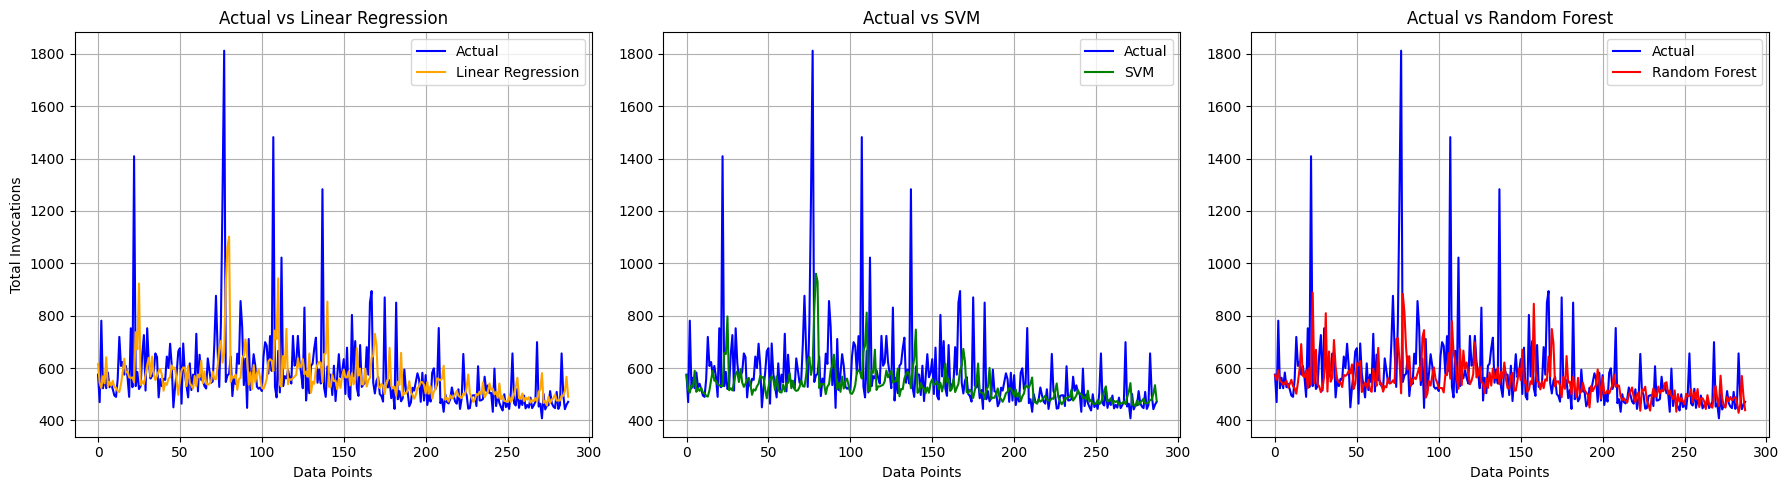

In [291]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  Actual vs Linear Regression
axes[0].plot(y_test.values, label="Actual", color="blue")
axes[0].plot(y_lr_pred, label="Linear Regression", color="orange")
axes[0].set_title("Actual vs Linear Regression")
axes[0].set_xlabel("Data Points")
axes[0].set_ylabel("Total Invocations")
axes[0].legend()
axes[0].grid(True)

#  Actual vs SVM
axes[1].plot(y_test.values, label="Actual", color="blue")
axes[1].plot(y_svm_pred, label="SVM", color="green")
axes[1].set_title("Actual vs SVM")
axes[1].set_xlabel("Data Points")
axes[1].legend()
axes[1].grid(True)

#  Actual vs Random Forest
axes[2].plot(y_test.values, label="Actual", color="blue")
axes[2].plot(y_rf_pred, label="Random Forest", color="red")
axes[2].set_title("Actual vs Random Forest")
axes[2].set_xlabel("Data Points")
axes[2].legend()
axes[2].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Classification

### Logistic Regression Model

In [292]:
def get_classification_data():
  cdf = pd.read_csv("/content/day_01.csv")
  cdf = get_preprocess_data_without_differencing(cdf) #without differencing
  cdf_with_differncing = apply_differencing(cdf) #with differencing
  threshold = cdf_with_differncing['diff_total_invocations'].median()
  cdf_with_differncing['target'] = cdf_with_differncing['diff_total_invocations'].apply(lambda x: 1 if x >= threshold else 0)

  return cdf_with_differncing


In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [294]:
lrdf = get_classification_data()
lrdf.head()
X = lrdf[['lag_1', 'lag_2', 'lag_3']]
y = lrdf['target']

X_lor_train, X_lor_test, y_lor_train, y_lor_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_lor_train, y_lor_train)

# Predict
y_lor_pred = log_reg.predict(X_lor_test)

# Evaluate
print("Accuracy:", accuracy_score(y_lor_test, y_lor_pred))
print("Classification Report:\n", classification_report(y_lor_test, y_lor_pred))

Accuracy: 0.7291666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69       132
           1       0.73      0.79      0.76       156

    accuracy                           0.73       288
   macro avg       0.73      0.72      0.72       288
weighted avg       0.73      0.73      0.73       288



In [301]:
lrdf.to_csv("classificatoin_preprocessed_dataset.csv")

### Support vector machines

In [295]:
svdf = get_classification_data()
X = svdf[['lag_1', 'lag_2', 'lag_3']]
y = svdf['target']

X_svm2_train, X_svm2_test, y_svm2_train, y_svm2_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [296]:
from sklearn.svm import SVC
# Support Vector Machine (SVM) Classifier
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf' or 'poly'
svm_model.fit(X_svm2_train, y_svm2_train)

# Predict with SVM
y_pred_svm = svm_model.predict(X_svm2_test)

# Evaluate SVM
print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_svm2_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_svm2_test, y_pred_svm))


SVM Results:
Accuracy: 0.7222222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       132
           1       0.72      0.79      0.76       156

    accuracy                           0.72       288
   macro avg       0.72      0.72      0.72       288
weighted avg       0.72      0.72      0.72       288



### Random Forest Classifier

In [269]:
rfdf2 = get_classification_data()
X = rfdf2[['lag_1', 'lag_2', 'lag_3']]
y = rfdf2['target']

# Split the data
X_rfdf2_train, X_rfdf2_test, y_rfdf2_train, y_rfdf2_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [270]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_model.fit(X_rfdf2_train, y_rfdf2_train)

# Predict with Random Forest
y_pred_rf = rf_model.predict(X_rfdf2_test)

# Evaluate Random Forest
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_rfdf2_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_rfdf2_test, y_pred_rf))

Random Forest Results:
Accuracy: 0.7048611111111112
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68       132
           1       0.73      0.72      0.73       156

    accuracy                           0.70       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.71      0.70      0.70       288



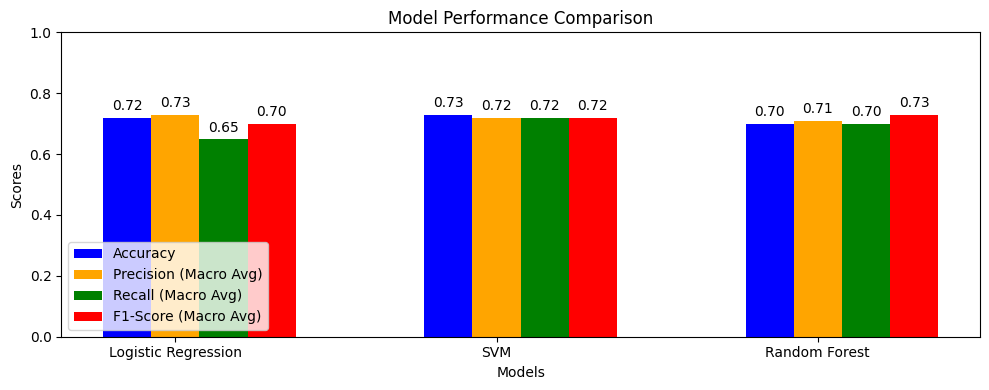

In [297]:
import matplotlib.pyplot as plt
import numpy as np

# hard coding values of accuracy, precision, recall and f1 score
models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracy = [0.72, 0.73, 0.70]  # Accuracy values
precision = [0.73, 0.72, 0.71]       # Precision values (macro avg)
recall = [0.65, 0.72, 0.70]          # Recall values (macro avg)
f1_score = [0.70, 0.72, 0.73]        # F1-score values (macro avg)

x = np.arange(len(models))  # Label locations
width = 0.15  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 4))

# Plot bars for each metric
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='blue')
rects2 = ax.bar(x, precision, width, label='Precision (Macro Avg)', color='orange')
rects3 = ax.bar(x + width, recall, width, label='Recall (Macro Avg)', color='green')
rects4 = ax.bar(x + 2 * width, f1_score, width, label='F1-Score (Macro Avg)', color='red')


ax.set_ylim(0, 1)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()